<a href="https://colab.research.google.com/github/JeLaKo/apple-tree-disease/blob/main/Milestone4b_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the data and importing the necessary libraries

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import math as tfmath
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
# import mlxtend package for confusion matrix
import mlxtend
                                                          
print(mlxtend.__version__) 

! pip install mlxtend --upgrade --no-deps

print(mlxtend.__version__) 

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


0.19.0
0.19.0


In [4]:
'''
Only run the following cells if data needs to be newly downloaded !
'''
# !pip install -U -q kaggle==1.5.8

'\nOnly run the following cells if data needs to be newly downloaded !\n'

In [5]:
# %cd /content/gdrive/MyDrive/MLP/

In [6]:
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/MLP/"
# ! kaggle competitions download -c plant-pathology-2021-fgvc8

In [7]:
# ! mkdir train

In [8]:
# ! unzip -q plant-pathology-2021-fgvc8.zip -d train

Data processing


In [4]:
%cd /content/gdrive/MyDrive/MLP/train/

/content/gdrive/MyDrive/MLP/train


In [32]:
# read training data
df = pd.read_csv('train.csv')
print(df.head(2))

                  image                           labels
0  800113bb65efe69e.jpg                          healthy
1  8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex


In [33]:
# remove all combined classes from dataset
df = df.set_index('labels')
df = df.drop('scab frog_eye_leaf_spot complex', axis = 0)
df = df.drop('scab frog_eye_leaf_spot', axis = 0)
df = df.drop('frog_eye_leaf_spot complex', axis = 0)
df = df.drop('powdery_mildew complex', axis = 0)
df = df.drop('rust complex', axis = 0)
df = df.drop('rust frog_eye_leaf_spot', axis = 0)
df = df.reset_index()
print(df.head())



    labels                 image
0  healthy  800113bb65efe69e.jpg
1     scab  80070f7fb5e2ccaa.jpg
2     scab  80077517781fb94f.jpg
3  complex  800cbf0ff87721f8.jpg
4  healthy  800edef467d27c15.jpg


In [34]:
# change combined classes to only contain a single label
new_labels = df['labels'].to_list()

# for i in range(len(new_labels)):
#   if new_labels[i] == 'scab frog_eye_leaf_spot complex' or new_labels[i] == 'scab frog_eye_leaf_spot':
#     new_labels[i] = 'scab'
#   elif new_labels[i] == 'frog_eye_leaf_spot complex':
#     new_labels[i] = 'frog_eye_leaf_spot'
#   elif new_labels[i] == 'powdery_mildew complex':
#     new_labels[i] = 'powdery_mildew'
#   elif new_labels[i] == 'rust complex' or new_labels[i] == 'rust frog_eye_leaf_spot':
#     new_labels[i] = 'rust'

# replace labels with adjusted labels in dataframe
df['adjusted labels'] = np.array(new_labels)
df = df.drop('labels', axis = 1)

In [26]:
def sample(df, sample_size):
  """
  This function gets an equal sample inclusive of all classes from the input dataframe
  """
  df_sampled = []
  classes = df['adjusted labels'].unique()

  for i in classes:
      g = df[df['adjusted labels'] == i].sample(sample_size)
      df_sampled.append(g)

  df_sampled = pd.concat(df_sampled)
  return df_sampled

# select sample from dataframe
df_sampled = sample(df, 1184)
print(df_sampled.head(2))

                      image adjusted labels
15875  f80e01ceec770da3.jpg         healthy
14709  f0724db01e45ef92.jpg         healthy


In [31]:
def one_hot(df):
  """
  This function returns all classes and combination of classes found in the input-dataframe, and returns
  the one-hot encoded version
  """
  one_hot = pd.get_dummies(df['adjusted labels'])
  df = df.drop('adjusted labels', axis = 1)
  df = df.join(one_hot)
  return df

# convert labels within dataframe to one-hot encoded classes
df_onehot = one_hot(df_sampled)
print(df_onehot.head(2))

                  image  complex  ...  rust  scab
0  800113bb65efe69e.jpg        0  ...     0     0
1  80070f7fb5e2ccaa.jpg        0  ...     0     1

[2 rows x 7 columns]


Image-data processing

In [14]:
'''
Only run this cell if images need resizing !
'''
# # create new directory
# ! mkdir resized_train_images

# # gather names of all images in the image-directory
# train_images = os.listdir('train_images/')

# # resize all images and save it to a new directory 
# for image in train_images:
#   img = cv2.imread('train_images/' + image)
#   resized_img = cv2.resize(img, (96, 96)) 
#   cv2.imwrite('resized_train_images/' + image, resized_img)


'\nOnly run this cell if images need resizing !\n'

In [15]:
# convert dataframe to a hashable list; dictionary
df_dict = df_onehot.set_index('image').T.to_dict('list')

# gather names of all images in the resized directory
resized_images = os.listdir('resized_train_images/')

images = []
# find corresponding image from the resized directory to the selected sample found
# in dictionary and add that to a list
for image in df_dict.keys():
  if image in resized_images:
    img_resized = cv2.imread('resized_train_images/' + image) 
    images.append(img_resized)

In [16]:
# convert image list to array
images = np.array(images)

# convert dictionary values to array
labels = np.array(list(df_dict.values()))

# split data
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size = 0.3, random_state=42)

Building and training the network

In [17]:
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, preprocessing

def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):

    # optimizer = keras.optimizers.Adam(lr = 0.01)
    model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

Epoch 1/80
156/156 [==============================] - 23s 142ms/step - loss: 2.3982 - accuracy: 0.1933 - val_loss: 1.7450 - val_accuracy: 0.2458
Epoch 2/80
156/156 [==============================] - 22s 140ms/step - loss: 2.0150 - accuracy: 0.2062 - val_loss: 1.6587 - val_accuracy: 0.2974
Epoch 3/80
156/156 [==============================] - 21s 137ms/step - loss: 1.9322 - accuracy: 0.2150 - val_loss: 1.7843 - val_accuracy: 0.2566
Epoch 4/80
156/156 [==============================] - 21s 136ms/step - loss: 1.8628 - accuracy: 0.2327 - val_loss: 1.7769 - val_accuracy: 0.2481
Epoch 5/80
156/156 [==============================] - 21s 135ms/step - loss: 1.8134 - accuracy: 0.2323 - val_loss: 1.6470 - val_accuracy: 0.2941
Epoch 6/80
156/156 [==============================] - 21s 135ms/step - loss: 1.7861 - accuracy: 0.2462 - val_loss: 1.6072 - val_accuracy: 0.3241
Epoch 7/80
156/156 [==============================] - 21s 133ms/step - loss: 1.7582 - accuracy: 0.2534 - val_loss: 1.6937 - val_ac

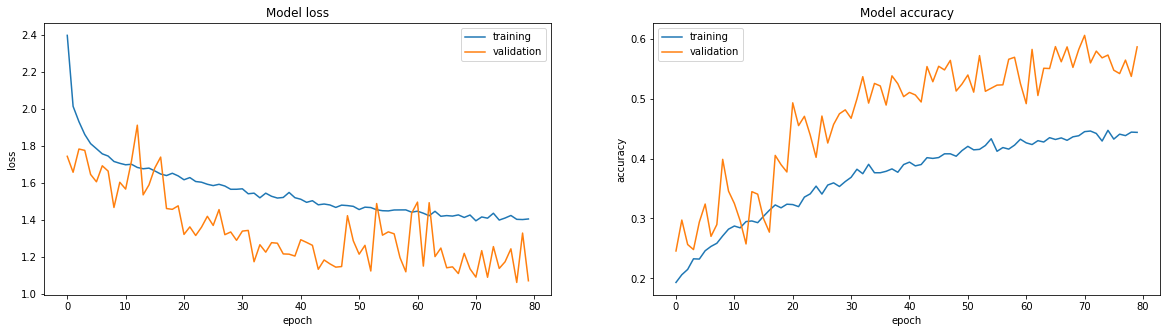

67/67 [==============================] - 1s 15ms/step - loss: 1.0727 - accuracy: 0.5863
Validation Accuracy: 0.5863039493560791


In [25]:
# ML MODEL ARCHITECTURE
# Define Sequential model
model = models.Sequential()

# create convolutional layer and max pooling layer
model.add(layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# create convolutional layer (larger) and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())

# add Conv2D layer with 128 filters and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(128, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())

# add Conv2D layer with 256 filters and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(256, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# add Conv2D layer with 32 filters and max pooling layer
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.5), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

# flatten layers
model.add(layers.Flatten())
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.5)))

# apply softmax activation for final layer classification
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(6, activation='softmax'))

# normalize input data: set preprocesing dictionary
preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# augment data: set augmentation dictionary
augment = {'horizontal_flip': True, 
           'vertical_flip': True, 
           'rotation_range': 20, 
           'width_shift_range': 0.1, 
           'height_shift_range': 0.1, 
           'zoom_range': [0,1.5], 
           'brightness_range': [0,1.5],
           'channel_shift_range' : 0.9,
           'shear_range' : 0.9}

# run training and evaluation function
train_and_evaluate(model, x_train, y_train, x_val, y_val, preprocess, epochs = 80, augment = augment)


In [29]:
model.summary()

Confusion Matrix

array(['healthy', 'scab', 'complex', 'rust', 'frog_eye_leaf_spot',
       'powdery_mildew'], dtype=object)

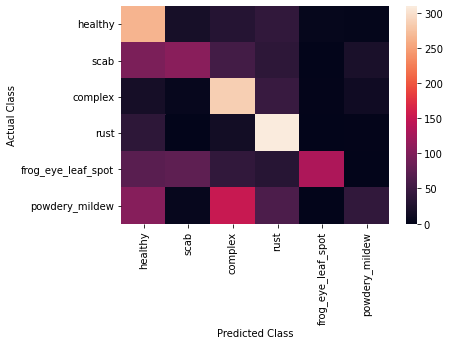

tf.Tensor(
[[265  19  31  41   4   3]
 [ 97 107  55  37   1  21]
 [ 17   5 286  47   2  13]
 [ 37   0  15 309   0   2]
 [ 72  76  41  32 132   0]
 [105   6 151  62   1  40]], shape=(6, 6), dtype=int32)


In [20]:
# select classes
classes = df['adjusted labels'].unique()
display(classes)

# gather actual and predicted classes
y_true = tf.argmax(y_val, axis=1)
# y_pred = tf.keras.utils.to_categorical(y_pred, num_classes = 6)
y_pred = tf.argmax(model.predict(x_val), axis = 1)

# plot confusion matrix 1
conf_matrix = tfmath.confusion_matrix(y_true, y_pred, num_classes = 6)

ax = sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes)
ax.set(xlabel='Predicted Class', ylabel='Actual Class')
plt.show()

print(conf_matrix)

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7f33e53f50>)

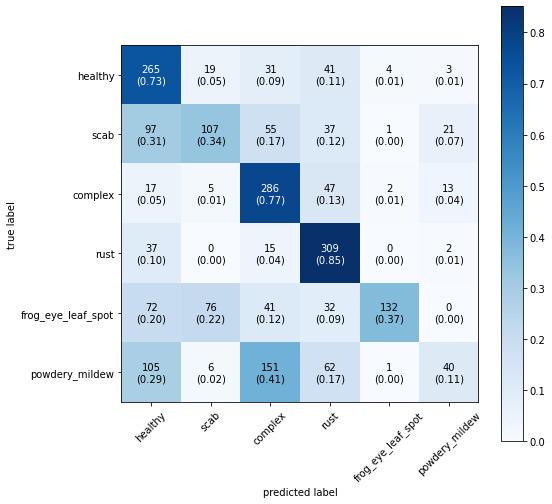

In [26]:
# plot confusion matrix 2
mtrx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat = mtrx, figsize=(8, 8), class_names=classes, colorbar=True, show_normed = True)

Epoch 1/80
156/156 [==============================] - 33s 206ms/step - loss: 1.8359 - accuracy: 0.1659 - val_loss: 1.7923 - val_accuracy: 0.1656
Epoch 2/80
156/156 [==============================] - 32s 205ms/step - loss: 1.7931 - accuracy: 0.1621 - val_loss: 1.7925 - val_accuracy: 0.1703
Epoch 3/80
156/156 [==============================] - 34s 216ms/step - loss: 1.7925 - accuracy: 0.1655 - val_loss: 1.7928 - val_accuracy: 0.1492
Epoch 4/80
156/156 [==============================] - 32s 205ms/step - loss: 1.7922 - accuracy: 0.1732 - val_loss: 1.7924 - val_accuracy: 0.1492
Epoch 5/80
156/156 [==============================] - 32s 203ms/step - loss: 1.7924 - accuracy: 0.1657 - val_loss: 1.7930 - val_accuracy: 0.1492
Epoch 6/80
156/156 [==============================] - 32s 203ms/step - loss: 1.7922 - accuracy: 0.1702 - val_loss: 1.7929 - val_accuracy: 0.1492
Epoch 7/80
156/156 [==============================] - 34s 217ms/step - loss: 1.7921 - accuracy: 0.1742 - val_loss: 1.7931 - val_ac

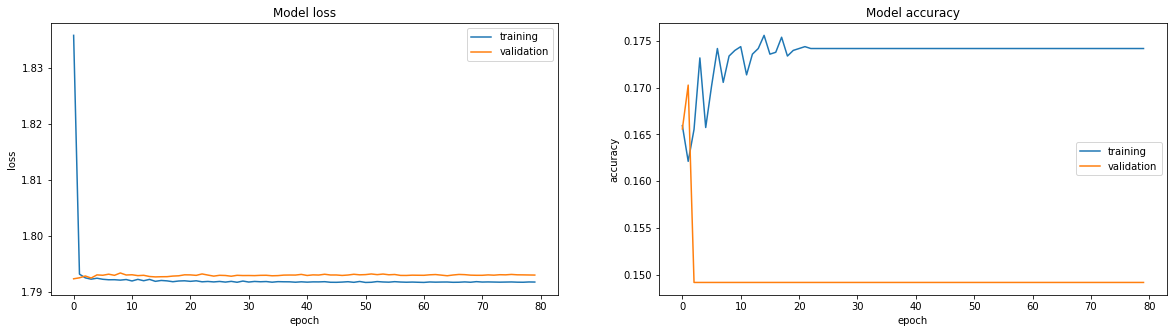

67/67 [==============================] - 4s 55ms/step - loss: 1.7930 - accuracy: 0.1492
Validation Accuracy: 0.14915572106838226


In [31]:
# # VGG-16 model

# # Define Sequential model
# modelVGG_16 = models.Sequential()

# # create convolutional layers and max pooling layer
# modelVGG_16.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu",input_shape=(96, 96, 3)))
# modelVGG_16.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.MaxPooling2D((2, 2)))

# # create convolutional layers and max pooling layer
# modelVGG_16.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.MaxPooling2D((2, 2)))

# # create convolutional layers and max pooling layer
# modelVGG_16.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.MaxPooling2D((2, 2)))

# # create convolutional layers and max pooling layer
# modelVGG_16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# modelVGG_16.add(layers.MaxPooling2D((2, 2)))

# # # create convolutional layers and max pooling layer
# # modelVGG_16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# # modelVGG_16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# # modelVGG_16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# # modelVGG_16.add(layers.MaxPooling2D((2, 2)))

# # flatten layer
# modelVGG_16.add(layers.Flatten())
# modelVGG_16.add(layers.Dense(4096, activation="relu"))
# modelVGG_16.add(tf.keras.layers.Dropout(0.5))
# modelVGG_16.add(layers.Dense(4096, activation="relu"))
# modelVGG_16.add(tf.keras.layers.Dropout(0.5))

# # predict
# modelVGG_16.add(layers.Dense(6, activation='softmax'))

# # normalize input data: set preprocesing dictionary
# preprocess = {'featurewise_center': True, 'featurewise_std_normalization' : True}

# # augment data: set augmentation dictionary
# augment = {'horizontal_flip': True, 
#            'vertical_flip': True, 
#            'rotation_range': 20, 
#            'width_shift_range': 0.1, 
#            'height_shift_range': 0.1, 
#            'zoom_range': [0,1.5], 
#            'brightness_range': [0,1.5],
#            'channel_shift_range' : 0.9,
#            'shear_range' : 0.9}

# # run training and evaluation function
# train_and_evaluate(modelVGG_16, x_train, y_train, x_val, y_val, preprocess, epochs = 80, augment = augment)

In [32]:
# modelVGG_16.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 96, 96, 64)        1792      
                                                                 
 conv2d_45 (Conv2D)          (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 conv2d_47 (Conv2D)          (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 24, 24, 128)      0         
 g2D)                                                 